<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CIFAR10PyTorchClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 
* https://www.cs.toronto.edu/~kriz/cifar.html
* 10 categories
* 3 channel (RGB)

# Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

# Data

In [38]:
train = datasets.CIFAR10(root='.', train=True,  download=True, transform=transforms.ToTensor())
test  = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())
print(train) 
print(test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()


In [0]:
train_loader = DataLoader(train, batch_size=10, shuffle=True)
test_loader  = DataLoader(test,  batch_size=10, shuffle=False)

In [0]:
class_names = ['plane',
               'car',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

In [41]:
for images, labels in train_loader:
  break
print(labels)
print([class_names[lbl] for lbl in labels])

tensor([8, 6, 8, 6, 8, 1, 3, 0, 5, 1])
['ship', 'frog', 'ship', 'frog', 'ship', 'car', 'cat', 'plane', 'dog', 'car']


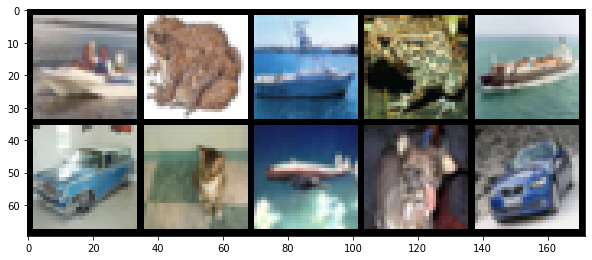

In [42]:
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,8))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

# Model
* Input:
  * 32 x 32 Images
* Into our 1st Conv layer:
  * Width     = 32
  * No padding      =  -2
  * MaxPool 2d Stride 2 = / 2
  * Out Conv = (32 - 2) / 2 = 15
  * 6 Filters, Relu
* Into our 2nd Conv layer:
  * Width = 15
  * No padding = -2
  * MaxPool 2d Stride 2 = / 2
  * Out Conv = (15 - 2) / 2 = 6.5
  * 16 Filters, Relu
* Fully Connected 1st Layer
  * Flatten
  * In = 6 * 6 Filters * 16 Filters = 576 
  * Out = 120
  * Relu
* Fully Connected 2nd Layer
  * In 120
  * Out 60
  * Relu
* Output
  * In 60
  * Out 10
  * Softmax

In [0]:
class ConvNetModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6,  kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)
    self.fc1   = nn.Linear(6 * 6 * 16, 120)
    self.fc2   = nn.Linear(120, 60)
    self.fc3   = nn.Linear(60, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 6 * 6 * 16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [44]:
model = ConvNetModel()
model

ConvNetModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)

In [45]:
for p in model.parameters():
  print(p.numel())

450
6
864
16
69120
120
7200
60
600
10


# Optimizer & Loss Function

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001) # 3e-4

# Training Loop

In [47]:
start = time.time()

# Epochs & Placeholders for Plotting
epochs = 10
loss_train = []
loss_test  = []
correct_train = []
correct_test  = []

# Loop Epochs
for loop in range(epochs):
  epoch_correct_train = 0
  epoch_correct_test  = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1

    # Forward Pass 
    y_hat = model(X_train)
    loss  = criterion(y_hat, y_train)

    # Accuracy
    pred = y_hat.argmax(1)
    batch_correct_train = (pred == y_train).sum()
    epoch_correct_train += batch_correct_train

    # Back
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log
    if b % 1000 == 0:
      print(f'Epoch {loop}  Batch {b} ({10 * b} / 50000)  Loss {loss.item():.3f}  Accuracy {epoch_correct_train.item() * 100. / (10 * b):.2f}')

  # Epoch Loss & Accuracy
  loss_train.append(loss)
  correct_train.append(epoch_correct_train)

  # Run on Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_hat = model(X_test)
      pred = y_hat.argmax(1)
      epoch_correct_test += (pred == y_test).sum()
    loss = criterion(y_hat, y_test)
    loss_test.append(loss)
    correct_test.append(epoch_correct_test)

# Total Time
print(time.time() - start)

Epoch 0  Batch 1000 (10000 / 50000)  Loss 1.487  Accuracy 25.93
Epoch 0  Batch 2000 (20000 / 50000)  Loss 1.615  Accuracy 33.28
Epoch 0  Batch 3000 (30000 / 50000)  Loss 1.911  Accuracy 37.00
Epoch 0  Batch 4000 (40000 / 50000)  Loss 0.967  Accuracy 39.37
Epoch 0  Batch 5000 (50000 / 50000)  Loss 1.573  Accuracy 41.22
Epoch 1  Batch 1000 (10000 / 50000)  Loss 1.186  Accuracy 51.07
Epoch 1  Batch 2000 (20000 / 50000)  Loss 1.485  Accuracy 51.62
Epoch 1  Batch 3000 (30000 / 50000)  Loss 1.906  Accuracy 52.22
Epoch 1  Batch 4000 (40000 / 50000)  Loss 1.617  Accuracy 52.57
Epoch 1  Batch 5000 (50000 / 50000)  Loss 1.278  Accuracy 52.87
Epoch 2  Batch 1000 (10000 / 50000)  Loss 1.068  Accuracy 56.44
Epoch 2  Batch 2000 (20000 / 50000)  Loss 1.251  Accuracy 57.31
Epoch 2  Batch 3000 (30000 / 50000)  Loss 0.796  Accuracy 57.22
Epoch 2  Batch 4000 (40000 / 50000)  Loss 0.991  Accuracy 57.36
Epoch 2  Batch 5000 (50000 / 50000)  Loss 0.784  Accuracy 57.60
Epoch 3  Batch 1000 (10000 / 50000)  Los

# Results

## Losses

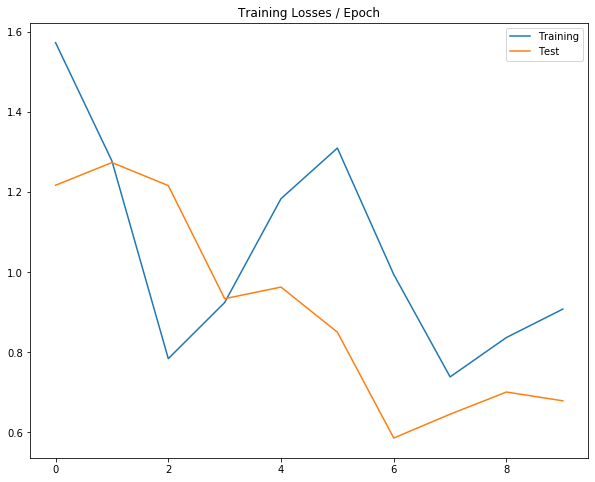

In [48]:
plt.figure(figsize=(10,8))
plt.plot(loss_train, label='Training')
plt.plot(loss_test, label='Test')
plt.title('Training Losses / Epoch')
plt.legend()

## Accuracy

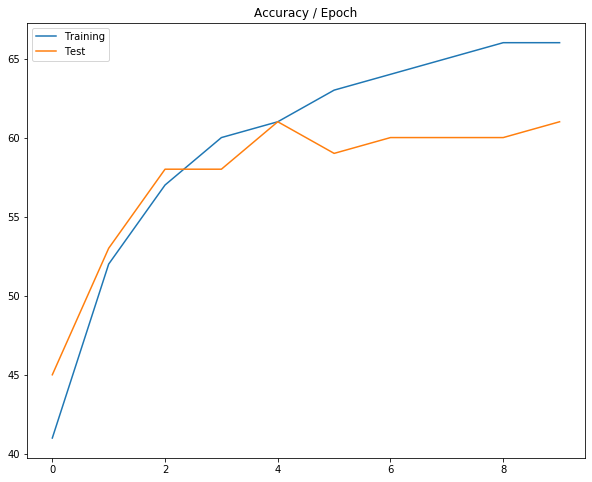

In [49]:
plt.figure(figsize=(10,8))
plt.plot([t / 500 for t in correct_train], label='Training')
plt.plot([t / 100 for t in correct_test],  label='Test')
plt.title('Accuracy / Epoch')
plt.legend()

## Confusion Matrix

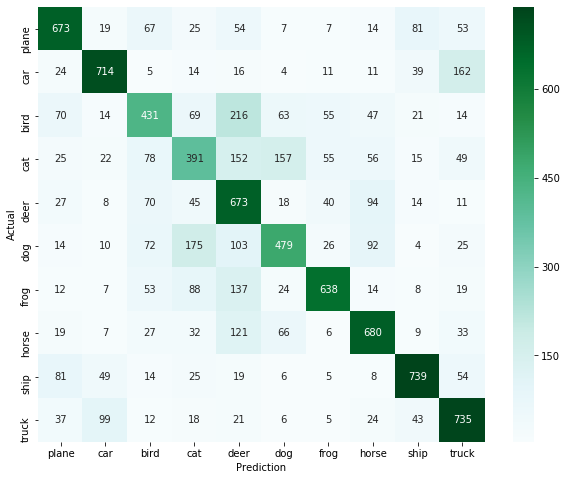

In [50]:
test_loader_all = DataLoader(test, batch_size=10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader_all:
    y_hat = model(X_test)
    pred  = y_hat.argmax(1)
    correct += (pred == y_test).sum()

cm = confusion_matrix(y_test.view(-1), pred.view(-1))
df = pd.DataFrame(cm, class_names, class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Improvements
* Data Augmentation for misclassifications
  * Cat / Dog
  * Truck / Car
  * Birds & Deers
* Larger capacity (6 & 16 Conv channels could be larger)